## הגדרות ומקדים

### ספריות

In [121]:
import os
import sys
import pandas as pd
import geopandas as gpd
import fiona

In [122]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### העלאת משתנים להרצת הקוד

In [123]:
path = os.getcwd()

software_root_folder = os.path.dirname(path)

software_folder_location = r'{}\current'.format(software_root_folder)

df_inputs_outputs = pd.read_excel(r'{}\inputs_outputs.xlsx'.format(software_folder_location))

forecast_version_folder_location=df_inputs_outputs['location'][1]

sys.path.append(software_root_folder)

## פונקציות

In [124]:
def drop_geo(geoDF):
    geoDF = geoDF.drop(columns='geometry')
    return geoDF

In [125]:
def double_taz_num(df):
    dup_taz_num=df.groupby(['Taz_num']).size().reset_index(name='count').query('count>1').Taz_num.to_list()
    return df.loc[df['Taz_num'].isin(dup_taz_num)]

In [126]:
def make_point(df):
    df_point=df.copy()
    df_point['centroid'] = df_point.representative_point()
    df_point=df_point.set_geometry('centroid')
    df_point=df_point.drop(columns=['geometry'],axis=1)
    return df_point

In [127]:
def up_load_gdb(path,layer_name):
    path='{}'.format(path)
    layer_list=fiona.listlayers(path)
    gpd_layer=gpd.read_file(path, layer=layer_list.index(layer_name))
    return gpd_layer

In [128]:
def up_load_shp(path):
    path='{}'.format(path)
    gpd_layer=gpd.read_file(path)
    return gpd_layer

In [129]:
def unique_id_in_one_taz(df_to_geoode,unique_field,gpd_for_geocode,taz):
    
    code_to_find=list(df_to_geoode[unique_field].unique())

    gpd_for_geocode_to_sum_by_taz=gpd_for_geocode[[unique_field,'geometry']].loc[gpd_for_geocode[unique_field].isin(code_to_find)]

    gpd_for_geocode_to_sum_by_taz=gpd.sjoin(taz[['Taz_num','geometry']],gpd_for_geocode_to_sum_by_taz)

    gpd_for_geocode_in_one_taz=list(gpd_for_geocode_to_sum_by_taz.groupby(unique_field)[['Taz_num']].nunique().query('Taz_num==1').reset_index()[unique_field])

    return gpd_for_geocode_in_one_taz

In [130]:
def up_load_df(folder_path,file_name):
    
    path_df=r'{}\{}.xlsx'.format(folder_path,file_name)
    df=pd.read_excel(path_df)
    df=df.dropna(how='all')

    return df

## העלת שכבות רלוונטים

In [131]:
path=r'{}\background_files'.format(software_folder_location)
student_chardi_not_gov=up_load_df(path,'מוסדות חינוך של המתבדלים _מעובד')
student_chardi_not_gov = gpd.GeoDataFrame(
    student_chardi_not_gov, geometry=gpd.points_from_xy(student_chardi_not_gov['x'], student_chardi_not_gov['y'],crs=2039))
student_chardi_not_gov=student_chardi_not_gov[['num_students','geometry']]

In [132]:
taz=up_load_shp(r'W:\Data\Forecast\Tools\forecast_git\create_forecast_basic\current\background_files\TAZ_V4_230518_Published.shp')

In [133]:
path=r'{}\background_files'.format(software_folder_location)
student_arab_not_gov=up_load_df(path,'מוסדות_חינוך_270616')
student_arab_not_gov=student_arab_not_gov.pivot_table(index='Taz_num',aggfunc=sum)[['num_student']]

In [134]:
needed_col=['Taz_num','SEA1',
 'SEA2',
 'SEA3',
 'UOA1',
 'UOA2',
 'UOA3',
 'ARA1',
 'ARA2',
 'ARA3']

In [135]:
upload_df_path=r'{}\Intermediates'.format(software_folder_location)
taz_students_gov=up_load_df(upload_df_path,'taz_with_gov_students')[needed_col]


DriverError: W:\Data\Forecast\Tools\forecast_git\create_forecast_basic\current\background_files: No such file or directory

## תלמידים לא במשרד החינוך

In [136]:
taz=taz.merge(taz_students_gov,on='Taz_num',how='left')

In [137]:
taz=taz.set_index('Taz_num')

In [138]:
student_chardi_not_gov_with_taz=gpd.sjoin(taz.reset_index(),student_chardi_not_gov)

In [139]:
taz['student_chardi_not_gov']=drop_geo(student_chardi_not_gov_with_taz).pivot_table(index='Taz_num',aggfunc=sum)[['num_students']]

In [140]:
taz['student_arab_not_gov']=student_arab_not_gov[['num_student']]

In [141]:
taz=taz.fillna(0)

In [142]:
def spilt_student_to_3(df,columns_to_split,columns_to_update):
    for i in columns_to_update:
        df['{}'.format(i)] += df['{}'.format(columns_to_split)] / 3
        return df


In [143]:
columns_to_update = ['ARA1', 'ARA2', 'ARA3']

In [144]:
taz=spilt_student_to_3(taz,'student_arab_not_gov',columns_to_update)

In [145]:
columns_to_update = ['UOA1', 'UOA2', 'UOA3']

In [146]:
taz=spilt_student_to_3(taz,'student_chardi_not_gov',columns_to_update)

In [147]:
taz=taz.fillna(0)

## סך תלמידים

In [148]:

columns_to_sum = [
    'SEA1',
    'SEA2',
    'SEA3',
    'UOA1',
    'UOA2',
    'UOA3',
    'ARA1',
    'ARA2',
    'ARA3'
]

# Sum the values across each row for the selected columns
taz['student'] = taz[columns_to_sum].sum(axis=1)


## השכלה גבוהה

In [149]:
emp_Education_per_uni_student=0.15

In [150]:
col=['geometry',
 'Univ_AR',
 'Univ_SE',
 'Univ_UO']

In [151]:
uni=up_load_df(r'{}\background_files'.format(software_folder_location),'uni_students')
uni = gpd.GeoDataFrame(
    uni, geometry= gpd.GeoSeries.from_wkt(uni['geometry']),crs=4326)
uni=uni.to_crs(crs=2039)
uni=uni.fillna(0)


In [152]:
employ_high_edu=up_load_df(r'{}\background_files'.format(software_folder_location),'employ_high_edu')
col=['edu_employ',
 'bussines_employ',
 'comm_employ']
employ_high_edu['emp_uni']=employ_high_edu[col].sum(axis=1)
uni=uni.merge(employ_high_edu,on='ID_camp',how='left')

In [153]:

columns_to_sum = [
 'Univ_AR',
 'Univ_SE',
 'Univ_UO'
]

# Sum the values across each row for the selected columns
uni['univ'] = uni[columns_to_sum].sum(axis=1)


In [154]:
uni.loc[uni['emp_uni'].isna(),'emp_uni']=uni['univ']*emp_Education_per_uni_student

In [155]:
uni_students_with_taz=gpd.sjoin(taz[['geometry']].reset_index(),uni)

In [156]:

col = ['Taz_num',
 'Univ_AR',
 'Univ_SE',
 'Univ_UO','univ','emp_uni']

In [157]:
uni_students_sum_by_taz=uni_students_with_taz[col].pivot_table(index='Taz_num',aggfunc=sum).reset_index()

In [158]:
taz=taz.merge(uni_students_sum_by_taz,on='Taz_num',how='left').fillna(0)

איפוס של אזורי תנועה פלסטניאים

In [159]:
col=['Univ_AR',
 'Univ_SE',
 'Univ_UO',
 'emp_uni',
 'univ']

In [160]:
taz.loc[taz['main_secto']=="Palestinian",col]=0

## ישיבות

In [161]:
taz=taz.fillna(0)

In [162]:
student_yeshiva=up_load_shp(r'{}\background_files\yeshiva.shp'.format(software_folder_location))

student_yeshiva=gpd.sjoin(taz[['Taz_num','geometry']],student_yeshiva)


In [163]:
student_yeshiva_by_gender_taz=drop_geo(student_yeshiva).pivot_table(index=['Taz_num','gender'],aggfunc=sum).reset_index()

In [164]:
col=['Taz_num', 'dorms_p00-',
 'dorms_p21-',
 'dorms_p26-',
 'dorms_tota',
 'emp','students']

In [165]:
student_yeshiva_by_taz=student_yeshiva_by_gender_taz.loc[student_yeshiva_by_gender_taz['gender']=='male'][col]

In [166]:
student_Seminar_by_taz=student_yeshiva_by_gender_taz.loc[student_yeshiva_by_gender_taz['gender']=='female'][col]

In [167]:
new_col=['Taz_num','yeshiva_dorms_pop_15', 'yeshiva_dorms_pop_20', 'yeshiva_dorms_pop_25', 'yeshiva_dorms_pop_sum', 'emp_from_Yeshiva_student', 'Yeshiva']

student_yeshiva_by_taz.columns=new_col

In [168]:
new_col=['Taz_num','Seminar_dorms_pop_15', 'Seminar_dorms_pop_20', 'Seminar_dorms_pop_25', 'Seminar_dorms_pop_sum', 'emp_from_Seminar_student', 'Seminar']

student_Seminar_by_taz.columns=new_col

In [169]:
taz=taz.merge(student_yeshiva_by_taz,on='Taz_num',how='left').fillna(0)

In [170]:
taz=taz.merge(student_Seminar_by_taz,on='Taz_num',how='left').fillna(0)

In [171]:
needed_col=['Taz_num','kollim_demand']

In [172]:
upload_df_path=r'{}\Intermediates'.format(software_folder_location)
taz_with_kollim_demand=up_load_df(upload_df_path,'taz_with_kollim_demand')[needed_col]

taz=taz.merge(taz_with_kollim_demand,on='Taz_num',how='left').fillna(0)

In [173]:
taz.loc[taz['main_secto']!='U_Orthodox','kollim_demand']=0  #אל אף שאנחנו יודעים שיש כוללים באזורים שהם לא מוגדרים כחרדים

taz['add_from_kollim_demand']=0

In [174]:
taz.loc[(taz['main_secto']=='U_Orthodox')&(taz['kollim_demand']>taz['Yeshiva']),'add_from_kollim_demand']=taz['kollim_demand']-taz['Yeshiva']

taz['student_yeshiva_and_kollim']=taz['add_from_kollim_demand']+taz['Yeshiva']

In [175]:
taz['UO_Hi_Ed']=taz['student_yeshiva_and_kollim']+taz['Seminar']

In [176]:
taz['emp_UO_Hi_Ed']=taz['emp_from_Seminar_student']+taz['emp_from_Yeshiva_student']

## מקדם מועסק חינוך לתלמידים



מקור לנתוני מועסקים בחינוך ירושלים יהודי :https://jerusaleminstitute.org.il/wp-content/uploads/2021/04/shnaton_G0721.pdf

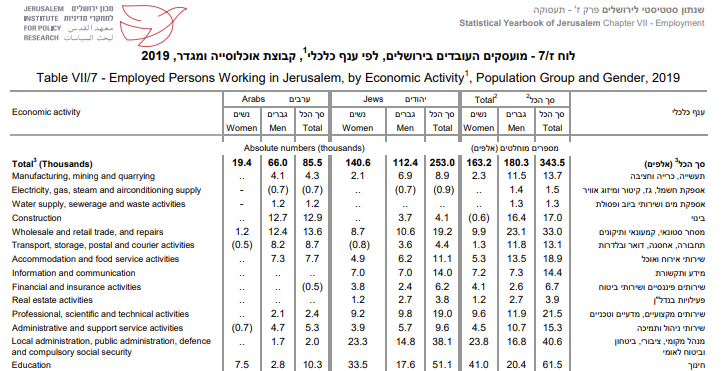

In [177]:
taz['jew']=0
taz.loc[(taz['main_secto']=="Jewish") |( taz['main_secto']=="U_Orthodox"),'jew']=1

הגעתי עד לכאן - צריך לייצר כמות תעסוקה בישיבות כי כנראה שיש טעות

In [179]:
emp_from_uni_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_uni']].sum().item()

In [180]:
emp_from_Yeshiva_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_UO_Hi_Ed']].sum().item()

In [181]:
emp_for_student_jeru_jew=51.1*1000-emp_from_Yeshiva_student_jeru-emp_from_uni_student_jeru

In [182]:
emp_education_per_student=round(taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['student']].sum().item()/emp_for_student_jeru_jew,2) 

In [183]:
emp_education_per_student

3.64

In [184]:
taz['emp_from_student']=taz['student']/emp_education_per_student

In [185]:
taz.loc[taz['main_secto']=="Palestinian",'emp_from_student']=0

In [186]:
taz['emp_Education']=taz['emp_from_student']+taz['emp_UO_Hi_Ed']+taz['emp_uni']